# Introduction
This colab worksheet provides a starting point for the computer vision assignment.

# Data Loading

In [1]:
# Download the data stored in a zipped numpy array from one of these two locations
# If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it
# rather than repeatedly downloading it.
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random


!wget "https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo" -O training_images.npz

# The test images (without points)
!wget "https://sussex.box.com/shared/static/i0apaktucm7y4od7k4ux69k8t1iue7w8" -O test_images.npz

# The example images are here
!wget "https://sussex.box.com/shared/static/aulkv3tf2fc0765yqgfm9am87vgn3p8a" -O examples.npz



--2024-05-16 14:31:53--  https://sussex.box.com/shared/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.box.com (sussex.box.com)... 74.112.186.144
Connecting to sussex.box.com (sussex.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-16 14:31:53--  https://sussex.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo [following]
--2024-05-16 14:31:53--  https://sussex.app.box.com/public/static/eb9cfqjn82zpzwjgfq5vqvg07t3aiqwo
Resolving sussex.app.box.com (sussex.app.box.com)... 74.112.186.144
Connecting to sussex.app.box.com (sussex.app.box.com)|74.112.186.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://euc1.b

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [2]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'cf2a926d2165322adcd19d2e88b2eb1cd200ea5c')
confirm_checksum('examples.npz', '0fadc9226e4c0efb4479c5c1bf79491d75828ad3')
confirm_checksum('test_images.npz', 'c7b4b297c7e5c5009706f893ad1fb77a2aa73f95')



# Load the data

In [3]:
# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(2811, 256, 256, 3) (2811, 44, 2)
(554, 256, 256, 3)
(6, 256, 256, 3)


### Face Alignment

### Pre-Processing

In [4]:
# Copy of the original RGB images to use for displaying
original_images = images
original_test_images = test_images
original_example_images = example_images

In [5]:
# adding noise to the input data
def add_random_noise(image, noise_level=0.05):
    mean = 0
    std = noise_level * np.amax(image)
    # noise is generated using the mean and standard deviation
    noise = np.random.normal(mean, std, image.shape)
    # noise is added to the image
    image_noisy = image + noise
    # the resulting image are clipped to the range [0, 255]
    image_noisy = np.clip(image_noisy, 0, 255)
    # the image is converted to unit8
    return image_noisy.astype(np.uint8)

In [6]:
# function to preprocess images
def preprocess_images(images, add_noise=True, smooth=True):
    if images.ndim == 4 and images.shape[-1] == 3:
        images = np.mean(images, axis=-1)
    processed_images = []
    for img in images:
        if add_noise:
            # adding noise
            img = add_random_noise(img)
        if smooth:
            # Guassian Blurr
            img = cv2.GaussianBlur(img, (5, 5), 0)
        # histogram equalization
        img = cv2.equalizeHist(img.astype(np.uint8))
        processed_images.append(img)
    return np.array(processed_images).reshape(images.shape[0], images.shape[1], images.shape[2], 1)


In [7]:
# Load and preprocess images
preprocessed_images = preprocess_images(images, add_noise=True, smooth=True)
preprocessed_test_images = preprocess_images(test_images, add_noise=True, smooth=True)
preprocessed_example_images = preprocess_images(example_images,add_noise=True, smooth=True)

### Edge Detection

### SIFT Features

In [8]:
def define_keypoints(image_shape, num_points_per_axis=4):
    keypoints = []
    # division to calculate step_x and step_y
    step_x, step_y = image_shape[1] // num_points_per_axis, image_shape[0] // num_points_per_axis
    for x in range(step_x, image_shape[1], step_x):
        for y in range(step_y, image_shape[0], step_y):
            # using cv2.KeyPoint object to store information about the keypoints
            keypoints.append(cv2.KeyPoint(x, y, step_x))
    return keypoints

In [9]:
# sift descriptior
def extract_sift_descriptors(images, keypoints):
    sift = cv2.SIFT_create()
    descriptors_list = []
    for img in images:
        # Compute the SIFT descriptors at pre-defined keypoints
        _, descriptors = sift.compute(img, keypoints)
        # Flatten descriptors to create a single feature vector per image
        if descriptors is not None:
            descriptors_list.append(descriptors.flatten())
        else:
            descriptors_list.append(np.zeros(len(keypoints) * 128))
    return np.array(descriptors_list)

In [10]:
keypoints = define_keypoints(original_images[1].shape)
training_features = extract_sift_descriptors(preprocessed_images,keypoints)

In [11]:
# Flatten the points to match the feature array
points_flattened = pts.reshape(pts.shape[0], -1)

In [12]:
# splitting the data into a training and validation set
from sklearn.model_selection import train_test_split
train_features, val_features, train_points, val_points = train_test_split(training_features, points_flattened, test_size=0.15, random_state=42)

In [13]:
from sklearn.linear_model import LinearRegression
# Train a linear regression model
model = LinearRegression()
model.fit(train_features, train_points)

# predict using the validation set
val_predictions = model.predict(val_features)

# Quantitative measures

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Mean Squared Error
mse = mean_squared_error(val_points, val_predictions)

# Mean Absolute Error
mae = mean_absolute_error(val_points, val_predictions)

print("Validation MSE:", mse)
print("Validation MAE:", mae)

Validation MSE: 59.998964023040635
Validation MAE: 5.659813222054568


In [15]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))

In [16]:
# euclid distance
val_ecd = euclid_dist(val_points, val_predictions)

# output euclid distance
print("Validation Euclid Distance:", val_ecd)

# average euclidean distance
average_distance = np.mean(val_ecd)
print("Average Validation Euclidean Distance:", average_distance)

# max euclidean distance
max_distance = np.max(val_ecd)
# min euclidean distance
min_distance = np.min(val_ecd)
print("Maximum Validation Euclidean Distance:", max_distance)
print("Minimum Validation Euclidean Distance:", min_distance)


Validation Euclid Distance: [12.93424912 10.79512507  7.24993596 ... 13.04465351 14.68345485
 15.49483255]
Average Validation Euclidean Distance: 8.895395028278754
Maximum Validation Euclidean Distance: 76.27195312292682
Minimum Validation Euclidean Distance: 0.019288784548616197


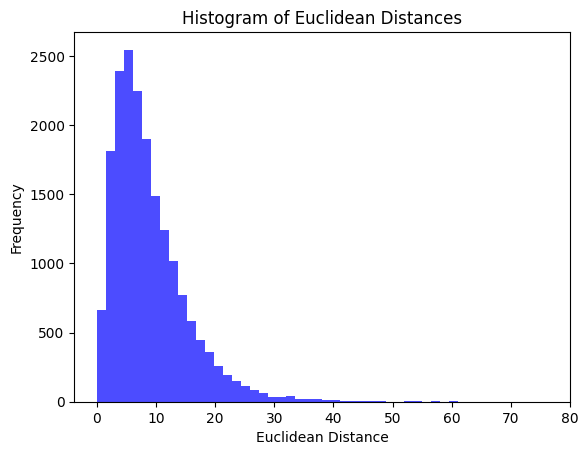

In [17]:
import matplotlib.pyplot as plt

# making a hisogram of euclidean distances
plt.hist(val_ecd, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Euclidean Distances')
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.show()

In [18]:
def visualize_predictions(images, predicted_points, num_samples=3):
    # Ensure there are enough images to sample
    if len(images) < num_samples:
        print("Not enough images to sample.")
        return

    # Randomly pick indices for images
    indices = random.sample(range(len(images)), num_samples)

    # Create a single figure with subplots in one row
    plt.figure(figsize=(30, 5))

    for i, idx in enumerate(indices):
        image = images[idx]
        points = predicted_points[idx].reshape(-1, 2)

        # Add subplot for each image
        ax = plt.subplot(1, num_samples, i + 1)
        ax.imshow(image, cmap='gray')
        ax.scatter(points[:, 0], points[:, 1], c='red')
        ax.set_title(f"Image Index: {idx}")
        ax.axis('off')

    plt.show()

In [19]:
# extracting the keypoints from the test dataset
testing_features = extract_sift_descriptors(preprocessed_test_images,keypoints)

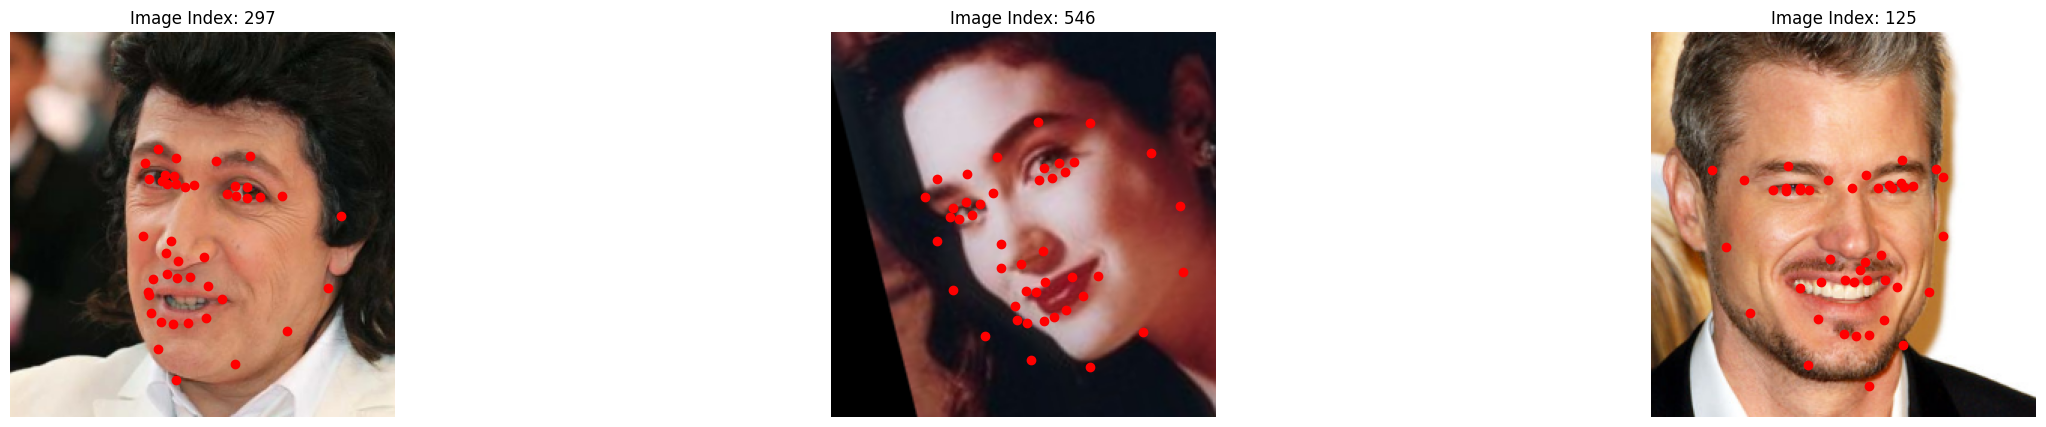

In [20]:
# getting the test_predictions
test_predictions = model.predict(testing_features)
visualize_predictions(original_test_images, test_predictions, num_samples=3)

In [21]:
# Generate keypoints assuming the models are trained with specific settings
example_features = extract_sift_descriptors(preprocessed_example_images, keypoints)

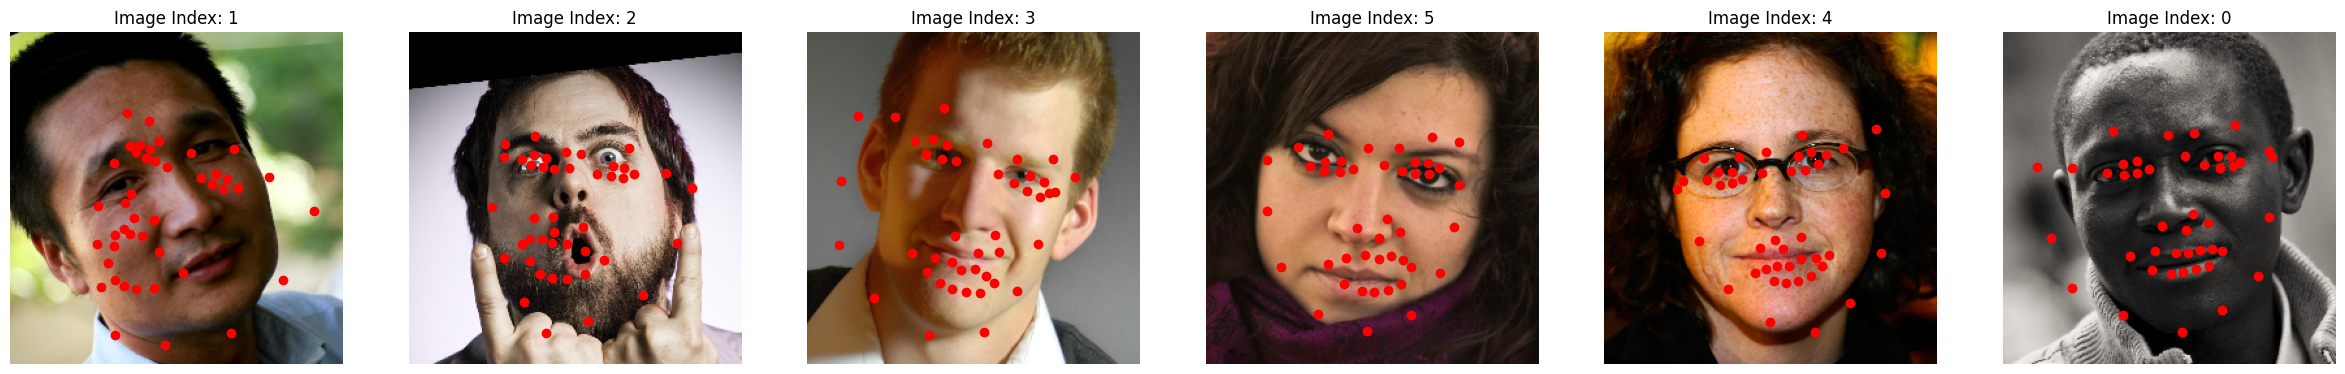

In [22]:
visualize_predictions(original_example_images, test_predictions, num_samples=len(example_images))

## Changing the Color

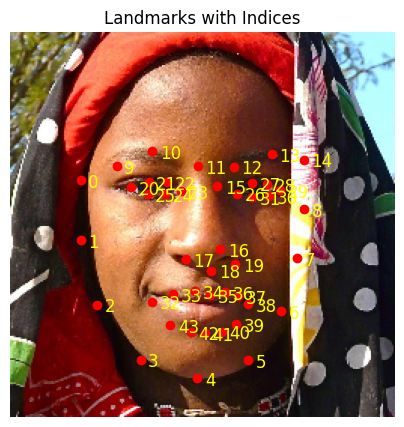

In [23]:
# Load an image to visualize
image = original_test_images[5]
points = test_predictions[5].reshape(-1,2)

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap='gray')

# Loop over the points and display them with their indices
for idx, (x, y) in enumerate(points):
    plt.scatter(x, y, color='red')  # Plot each point
    plt.text(x + 5, y + 5, str(idx), color='yellow', fontsize=12)  # Annotate each point with its index

plt.title('Landmarks with Indices')
plt.axis('off')
plt.show()

In [24]:
# Function to Create Masks from Landmarks
def create_masks(image, points, lip_indices, left_eye_indices, right_eye_indices):
    # masks initialized as arrays of zeros
    mask_lips = np.zeros_like(image)
    mask_left_eye = np.zeros_like(image)
    mask_right_eye = np.zeros_like(image)

    # extracting the relevant points using the indices provided and reshaping the points into a suitable format
    lips_points = points[lip_indices].reshape((-1, 1, 2)).astype(np.int32)
    left_eye_points = points[left_eye_indices].reshape((-1, 1, 2)).astype(np.int32)
    right_eye_points = points[right_eye_indices].reshape((-1, 1, 2)).astype(np.int32)

    # using fillPolly to fill the area defined by the points in each mask
    cv2.fillPoly(mask_lips, [lips_points], (255, 255, 255))
    cv2.fillPoly(mask_left_eye, [left_eye_points], (255, 255, 255))
    cv2.fillPoly(mask_right_eye, [right_eye_points], (255, 255, 255))

    return mask_lips, mask_left_eye, mask_right_eye

In [25]:
# Color Modification Function
def apply_color_change(image, mask_lips, mask_left_eye, mask_right_eye, lip_color, left_eye_color, right_eye_color):
    if len(image.shape) == 2:  # Grayscale to Color conversion
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    modified_image = image.copy()

    # Apply color to the lips
    # identifies the pixels of the lips using the lip mask
    lip_indices = (mask_lips[:, :, 0] == 255)
    modified_image[lip_indices] = lip_color

    # Apply color to the eyes
    # identifies the pixels of the eyes using the eyes mask
    left_eye_indices = (mask_left_eye[:, :, 0] == 255)
    modified_image[left_eye_indices] = left_eye_color

    right_eye_indices = (mask_right_eye[:, :, 0] == 255)
    modified_image[right_eye_indices] = right_eye_color

    return modified_image

In [26]:
# Function to process and visualize the changes
def process_and_visualize(image, points, lip_indices, left_eye_indices, right_eye_indices, lip_color, left_eye_color, right_eye_color):
    mask_lips, mask_left_eye, mask_right_eye = create_masks(image, points, lip_indices, left_eye_indices, right_eye_indices)
    modified_image = apply_color_change(image, mask_lips, mask_left_eye, mask_right_eye, lip_color, left_eye_color, right_eye_color)

    plt.imshow(cv2.cvtColor(modified_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for displaying
    plt.axis('off')

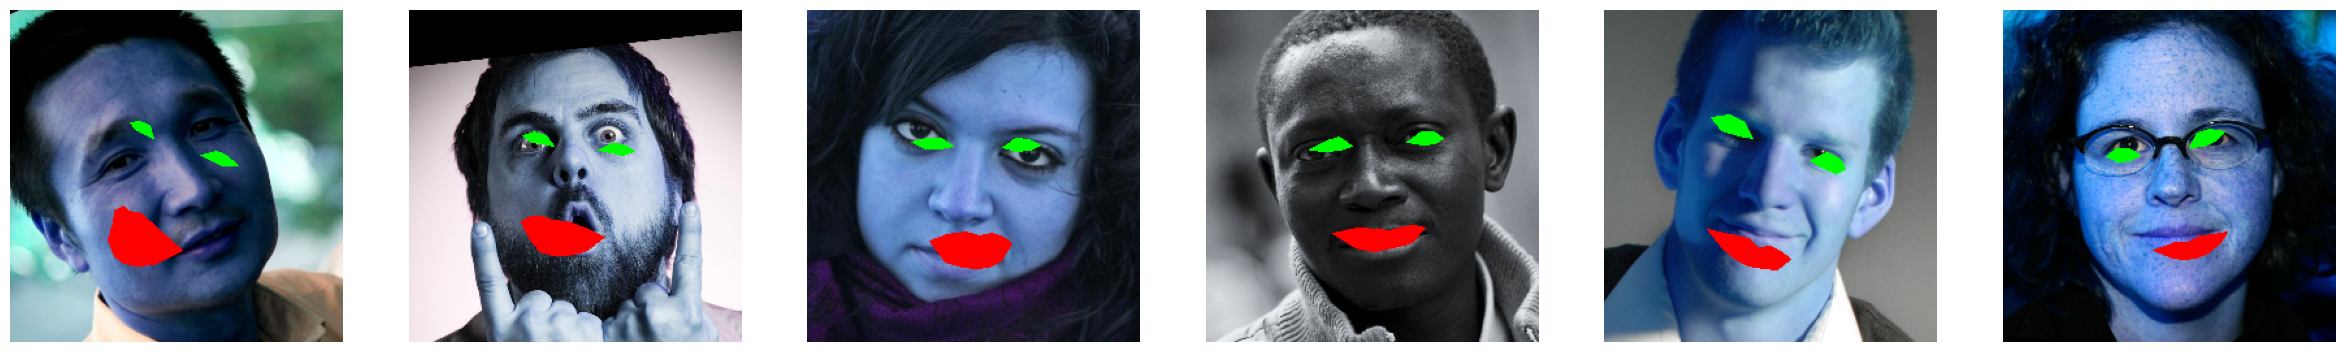

In [27]:
left_eye = [20,21,22,23,24,25]
right_eye = [26,27,28,29,30,31]
lips = [32,33,34,35,36,37,38,39,40,41,42,43]

num_images_to_display = 6
total_images = len(original_example_images)

selected_indices = random.sample(range(total_images), num_images_to_display)

plt.figure(figsize=(30, 5))

for i, idx in enumerate(selected_indices):
    image = original_example_images[idx]
    points = test_predictions[idx].reshape(-1, 2)
    plt.subplot(1, num_images_to_display, i + 1)
    process_and_visualize(image, points, lips, left_eye, right_eye, (0, 0, 255), (0, 255, 0), (0, 255, 0))

plt.show()

# Exporting results

In [28]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==44*2, 'wrong number of points provided. There should be 44 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')

In [29]:
save_as_csv(test_predictions)